# Study note about behaviors of learning ARD weights

In [1]:
import numpy
import sys
sys.path.append("../")
sys.path.append(".")
from model_criticism_mmd import ModelTrainerTorchBackend, MMD, ModelTrainerTheanoBackend
from model_criticism_mmd.backends import kernels_torch

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
import torch
device_obj = torch.device('cpu')

# Study: Correctness of ARD weightts

## objective

1. We confirm the computed ARD weights are as we expected.
2. We observe how the sigma value works on learninig the ARD weights.

## Settings

We generate the input data with the following way.

The input data has 3 dimensions. Only the 1st dimenstion has huge variance. The 2nd and 3rd features have the same mean and variance.

We cut the input data into 80 samples as `training` and 20 samples as `validation`.

In [3]:
size = 100
n_trial = 5
n_epoch = 500
batch_size = 200

result_stacks_with_sigma = []
result_stacks_without_sigma = []
for i_trial in range(0, n_trial):
    x_1st_dim = numpy.random.normal(loc=1.0, scale=0.0, size=size)
    y_1st_dim = numpy.random.normal(loc=1.0, scale=50.0, size=size)

    x_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))
    y_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))

    x = numpy.concatenate([numpy.reshape(x_1st_dim, (size, 1)), x_2_and_3_dim], axis=1)
    y = numpy.concatenate([numpy.reshape(y_1st_dim, (size, 1)), y_2_and_3_dim], axis=1)
    
    x_train = x[:80]
    y_train = y[:80]
    x_val = x[80:]
    y_val = y[80:]

    for n_dim in [0, 1, 2]:
        print(f'{n_dim+1} dim. mean(x)={x[:,n_dim].mean()} mean(y)={y[:,n_dim].mean()} var(x)={x[:,n_dim].var()} var(y)={y[:,n_dim].var()}')
    # end for
    
    # with sigma optimization
    trainer_theano = ModelTrainerTheanoBackend()
    trained_obj_theano = trainer_theano.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, opt_sigma=True, x_val=x_val, y_val=y_val, init_sigma_median=True)
    
    mmd_estimator_sigma_opt = MMD(kernels_torch.BasicRBFKernelFunction(opt_sigma=True, device_obj=device_obj), 
                                  device_obj=device_obj)
    trainer_torch = ModelTrainerTorchBackend(mmd_estimator=mmd_estimator_sigma_opt,
                                            device_obj=device_obj)
    trained_obj_torch = trainer_torch.train(x, y, num_epochs=n_epoch, batchsize=batch_size, x_val=x_val, y_val=y_val)
    sigma = numpy.exp(trained_obj_torch.kernel_function_obj.get_params()['log_sigma'].cpu().detach().numpy())

    result_stacks_with_sigma.append([
                             (x, y),
                             (trained_obj_theano.scales, trained_obj_torch.scales),
                             (trained_obj_theano.sigma, sigma)])
    # without sigma optimization
    trainer_theano = ModelTrainerTheanoBackend()
    trained_obj_theano = trainer_theano.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, opt_sigma=False, x_val=x_val, y_val=y_val, init_sigma_median=False, init_log_sigma=0.0)
    
    mmd_estimator = MMD(kernels_torch.BasicRBFKernelFunction(opt_sigma=False, device_obj=device_obj), 
                        device_obj=device_obj)
    trainer_torch = ModelTrainerTorchBackend(mmd_estimator=mmd_estimator,
                                            device_obj=device_obj)
    trained_obj_torch = trainer_torch.train(x, y, num_epochs=n_epoch, batchsize=batch_size, x_val=x_val, y_val=y_val)
    sigma = numpy.exp(trained_obj_torch.kernel_function_obj.get_params()['log_sigma'].cpu().detach().numpy())
    
    result_stacks_without_sigma.append([
                             (x, y),
                             (trained_obj_theano.scales, trained_obj_torch.scales),
                             (trained_obj_theano.sigma, sigma)])
# end for

Starting with sigma = median; optimizing it


1 dim. mean(x)=1.0 mean(y)=3.794244686785979 var(x)=0.0 var(y)=2476.663202810021
2 dim. mean(x)=10.000804314105228 mean(y)=10.012755435327513 var(x)=0.039063679232819566 var(y)=0.03607008589519812
3 dim. mean(x)=9.980861447174432 mean(y)=10.038935376916777 var(x)=0.03623773495314142 var(y)=0.03839255095424872


Compiling...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
done
Getting median initial sigma value...
21.3
Input dim 3, representation dim 3
Training on 80 samples (batch 200), validation on 20 (batch 1000)
2 parameters to optimize: scales, log_sigma
     0: avg train MMD^2  0.567266 obj -2.134350,  avg val MMD^2  0.327214  obj -1.126542  elapsed: 0s  sigma: 21.3
     5: avg train MMD^2  0.612720 obj -2.206668,  avg val MMD^2  0.377455  obj -1.200514  elapsed: 0s  sigma: 19.4
    25: avg train MMD^2  1.034153 obj -4.549388,  avg val MMD^2  0.964618  obj -2.595325  elapsed: 0s  sigma: 4.45
    50: avg train MMD^2  1.018105 obj -6.249617,  avg val MMD^2  1.063384  obj -4.735463  

1 dim. mean(x)=1.0 mean(y)=-3.2910783549023233 var(x)=0.0 var(y)=2662.981567345054
2 dim. mean(x)=10.018438658155072 mean(y)=9.995670546794102 var(x)=0.04023674640940499 var(y)=0.03665591755862935
3 dim. mean(x)=10.005264664080602 mean(y)=9.993287886522628 var(x)=0.04384700637937293 var(y)=0.049604940264592105


Compiling...
done
Getting median initial sigma value...
20.7
Input dim 3, representation dim 3
Training on 80 samples (batch 200), validation on 20 (batch 1000)
2 parameters to optimize: scales, log_sigma
     0: avg train MMD^2  0.551410 obj -2.121717,  avg val MMD^2  0.620558  obj -1.415628  elapsed: 0s  sigma: 20.7
     5: avg train MMD^2  0.604326 obj -2.214320,  avg val MMD^2  0.667969  obj -1.513940  elapsed: 0s  sigma: 18.6
    25: avg train MMD^2  0.981634 obj -3.500120,  avg val MMD^2  0.930130  obj -2.461990  elapsed: 0s  sigma: 5.97
    50: avg train MMD^2  1.017314 obj -7.145421,  avg val MMD^2  1.049584  obj -9.258734  elapsed: 0s  sigma: 1.95
   100: avg train MMD^2  1.014361 obj -7.560454,  avg val MMD^2  1.049944  obj -9.259077  elapsed: 0s  sigma: 0.661
   200: avg train MMD^2  1.012500 obj -9.222763,  avg val MMD^2  1.050000  obj -9.259131  elapsed: 0s  sigma: 0.026
   300: avg train MMD^2  1.012500 obj -9.222763,  avg val MMD^2  1.050000  obj -9.259131  elapsed: 0s  

1 dim. mean(x)=1.0 mean(y)=1.9536727141597885 var(x)=0.0 var(y)=2287.7127732846934
2 dim. mean(x)=10.013219358332682 mean(y)=10.000327963051317 var(x)=0.03579343880437631 var(y)=0.03756198812461435
3 dim. mean(x)=10.018103720956839 mean(y)=10.005794755851973 var(x)=0.03398136094511034 var(y)=0.057705280909693506


Compiling...
done
Getting median initial sigma value...
23.4
Input dim 3, representation dim 3
Training on 80 samples (batch 200), validation on 20 (batch 1000)
2 parameters to optimize: scales, log_sigma
     0: avg train MMD^2  0.625737 obj -2.269884,  avg val MMD^2  0.525925  obj -1.333024  elapsed: 0s  sigma: 23.4
     5: avg train MMD^2  0.689133 obj -2.329740,  avg val MMD^2  0.568959  obj -1.411603  elapsed: 0s  sigma: 21.5
    25: avg train MMD^2  0.979922 obj -3.018546,  avg val MMD^2  0.921840  obj -2.433018  elapsed: 0s  sigma: 9.23
    50: avg train MMD^2  0.986765 obj -3.615907,  avg val MMD^2  1.058491  obj -5.814967  elapsed: 0s  sigma: 3.18
   100: avg train MMD^2  1.014550 obj -7.208122,  avg val MMD^2  1.049912  obj -9.259047  elapsed: 0s  sigma: 0.377
   200: avg train MMD^2  1.012500 obj -9.222763,  avg val MMD^2  1.050000  obj -9.259131  elapsed: 0s  sigma: 0.0303
   300: avg train MMD^2  1.012500 obj -9.222763,  avg val MMD^2  1.050000  obj -9.259131  elapsed: 1s 

1 dim. mean(x)=1.0 mean(y)=3.5141730448836945 var(x)=0.0 var(y)=2881.06024075944
2 dim. mean(x)=10.012096976011295 mean(y)=9.978651888070065 var(x)=0.05096346174801573 var(y)=0.03442147996111479
3 dim. mean(x)=10.0139096859584 mean(y)=10.024546054276218 var(x)=0.04846329465893924 var(y)=0.03967969176731732


done
Getting median initial sigma value...
18.8
Input dim 3, representation dim 3
Training on 80 samples (batch 200), validation on 20 (batch 1000)
2 parameters to optimize: scales, log_sigma
     0: avg train MMD^2  0.530061 obj -2.093467,  avg val MMD^2  0.648698  obj -1.600537  elapsed: 0s  sigma: 18.8
     5: avg train MMD^2  0.566471 obj -2.140614,  avg val MMD^2  0.705651  obj -1.637193  elapsed: 0s  sigma: 17.4
    25: avg train MMD^2  0.864890 obj -2.817712,  avg val MMD^2  0.939518  obj -2.353111  elapsed: 0s  sigma: 7.76
    50: avg train MMD^2  0.970888 obj -4.747261,  avg val MMD^2  1.009157  obj -4.785852  elapsed: 0s  sigma: 1.34
   100: avg train MMD^2  1.014981 obj -6.967699,  avg val MMD^2  1.051825  obj -6.388079  elapsed: 0s  sigma: 0.448
   200: avg train MMD^2  0.025002 obj -5.521527,  avg val MMD^2  0.100000  obj -6.907755  elapsed: 0s  sigma: 0.00493
   300: avg train MMD^2  0.025000 obj -5.521461,  avg val MMD^2  0.100000  obj -6.907755  elapsed: 0s  sigma: 0.00

1 dim. mean(x)=1.0 mean(y)=5.902066248713997 var(x)=0.0 var(y)=2611.224226014868
2 dim. mean(x)=10.016997918750748 mean(y)=10.002626351954795 var(x)=0.03319854997013539 var(y)=0.0375069099885901
3 dim. mean(x)=10.001404982321501 mean(y)=10.027461486591214 var(x)=0.043176318612392815 var(y)=0.0388648905806243


Compiling...
done
Getting median initial sigma value...
24.7
Input dim 3, representation dim 3
Training on 80 samples (batch 200), validation on 20 (batch 1000)
2 parameters to optimize: scales, log_sigma
     0: avg train MMD^2  0.535444 obj -2.150013,  avg val MMD^2  0.333892  obj -1.197282  elapsed: 0s  sigma: 24.7
     5: avg train MMD^2  0.600144 obj -2.221044,  avg val MMD^2  0.395868  obj -1.293019  elapsed: 0s  sigma: 22.5
    25: avg train MMD^2  0.937827 obj -2.973677,  avg val MMD^2  0.729128  obj -1.668794  elapsed: 0s  sigma: 9.41
    50: avg train MMD^2  0.991852 obj -3.855594,  avg val MMD^2  0.978790  obj -3.344266  elapsed: 0s  sigma: 2.48
   100: avg train MMD^2  1.014392 obj -7.476147,  avg val MMD^2  1.049947  obj -9.259080  elapsed: 0s  sigma: 0.433
   200: avg train MMD^2  1.015030 obj -7.486661,  avg val MMD^2  1.050000  obj -9.259131  elapsed: 0s  sigma: 0.575
   300: avg train MMD^2  1.015032 obj -7.486662,  avg val MMD^2  1.050000  obj -9.259131  elapsed: 0s  

### Observations

(-10.0, 15.0)

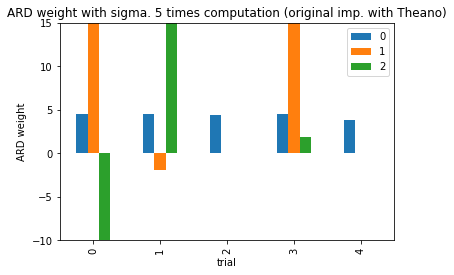

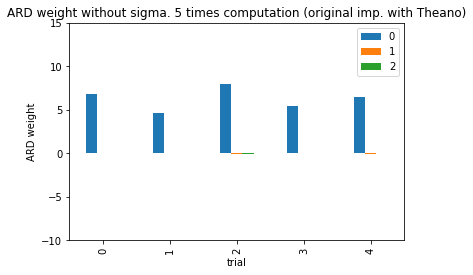

In [7]:
# Theano imp.
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas
import numpy

__df_with_sigma = []
__df_without_sigma = []
for trial_with_sigma, trial_without_sigma in zip(result_stacks_with_sigma, result_stacks_without_sigma):
    __df_with_sigma.append(trial_with_sigma[1][0])
    __df_without_sigma.append(trial_without_sigma[1][0])
# end for
df_with_sigma = pandas.DataFrame(__df_with_sigma, index = list(range(0, n_trial)))
ax = df_with_sigma.plot(kind='bar')
plt.title(f"ARD weight with sigma. {n_trial} times computation (original imp. with Theano)")
plt.ylabel("ARD weight")
plt.xlabel("trial")
ax.set_ylim(-10, 15)
# plot without sigma
df_without_sigma = pandas.DataFrame(__df_without_sigma, index = list(range(0, n_trial)))
ax = df_without_sigma.plot(kind='bar')
plt.title(f"ARD weight without sigma. {n_trial} times computation (original imp. with Theano)")
plt.ylabel("ARD weight")
plt.xlabel("trial")
ax.set_ylim(-10, 15)

(0.0, 15.0)

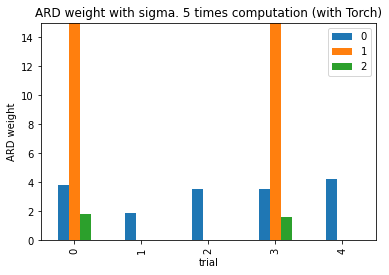

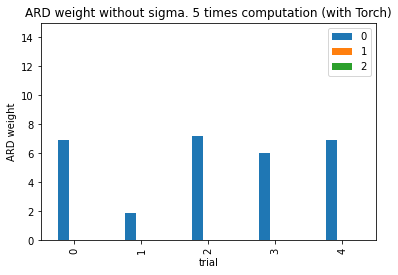

In [8]:
# Theano imp.
__df_with_sigma = []
__df_without_sigma = []
for trial_with_sigma, trial_without_sigma in zip(result_stacks_with_sigma, result_stacks_without_sigma):
    __df_with_sigma.append(trial_with_sigma[1][1])
    __df_without_sigma.append(trial_without_sigma[1][1])
# end for
df_with_sigma = pandas.DataFrame(__df_with_sigma, index = list(range(0, n_trial)))
ax = df_with_sigma.plot(kind='bar')
plt.title(f"ARD weight with sigma. {n_trial} times computation (with Torch)")
plt.ylabel("ARD weight")
plt.xlabel("trial")
ax.set_ylim(0, 15)
# plot without sigma
df_without_sigma = pandas.DataFrame(__df_without_sigma, index = list(range(0, n_trial)))
ax = df_without_sigma.plot(kind='bar')
plt.title(f"ARD weight without sigma. {n_trial} times computation (with Torch)")
plt.ylabel("ARD weight")
plt.xlabel("trial")
ax.set_ylim(0, 15)

### conclusion

The computed ARD weight will not be as we expected __if__ we optimize sigma value at the same time.

Then, we should tune __only scales (ARD weight)__ if we want to obtain the ARD weight.

In [9]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


# Study: stability of ARD weights

## Objective

To confirm the computed ARD weighted will be similar.

In the exp, we have the following conditions,

- the training data x and y are fixed.
- the validation data x and y are fixed.
- sigma will not be tuned

In [16]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas
import numpy

from model_criticism_mmd import ModelTrainerTheanoBackend, ModelTrainerTorchBackend, MMD, kernels_torch
import torch
device_obj = torch.device('cpu')

In [12]:
size = 100
x_1st_dim = numpy.random.normal(loc=1.0, scale=0.0, size=size)
y_1st_dim = numpy.random.normal(loc=1.0, scale=50.0, size=size)

x_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))
y_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))

x = numpy.concatenate([numpy.reshape(x_1st_dim, (size, 1)), x_2_and_3_dim], axis=1)
y = numpy.concatenate([numpy.reshape(y_1st_dim, (size, 1)), y_2_and_3_dim], axis=1)

x_train = x[:80]
y_train = y[:80]
x_val = x[80:]
y_val = y[80:]

for n_dim in [0, 1, 2]:
    print(f'{n_dim+1} dim. mean(x)={x[:,n_dim].mean()} mean(y)={y[:,n_dim].mean()} var(x)={x[:,n_dim].var()} var(y)={y[:,n_dim].var()}')
# end for

1 dim. mean(x)=1.0 mean(y)=2.795321498327029 var(x)=0.0 var(y)=2465.4126036498933
2 dim. mean(x)=9.968669428246267 mean(y)=10.004188273352877 var(x)=0.03581514211944157 var(y)=0.035821863318791385
3 dim. mean(x)=10.001445897071443 mean(y)=9.989482070893033 var(x)=0.03475761350379005 var(y)=0.04823557423398122


In [17]:
result_stacks = []
n_trial = 5
n_epoch = 500
batch_size = 200
is_opt_sigma = False
for i_trial in range(0, n_trial):
    trainer_theano = ModelTrainerTheanoBackend()
    trained_obj_theano = trainer_theano.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, opt_sigma=is_opt_sigma, x_val=x_val, y_val=y_val, init_sigma_median=False, init_log_sigma=0.0)

    mmd_estimator = MMD(kernel_function_obj=kernels_torch.BasicRBFKernelFunction(device_obj=device_obj, opt_sigma=is_opt_sigma),
                       device_obj=device_obj)
    trainer_torch = ModelTrainerTorchBackend(mmd_estimator, device_obj)
    trained_obj_torch = trainer_torch.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, x_val=x_val, y_val=y_val)

    result_stacks.append([
                             (trained_obj_theano.scales, trained_obj_torch.scales),
                             (trained_obj_theano.sigma, trained_obj_torch.sigma)
    ])
# end for

Using sigma = 1.0
Compiling...
done
Input dim 3, representation dim 3
Training on 80 samples (batch 200), validation on 20 (batch 1000)
1 parameters to optimize: scales
     0: avg train MMD^2  0.879545 obj -3.176400,  avg val MMD^2  0.866655  obj -2.362045  elapsed: 0s
     5: avg train MMD^2  0.881397 obj -3.194998,  avg val MMD^2  0.876319  obj -2.383594  elapsed: 0s
    25: avg train MMD^2  0.899503 obj -3.357453,  avg val MMD^2  0.920247  obj -2.497681  elapsed: 0s
    50: avg train MMD^2  0.915665 obj -3.487402,  avg val MMD^2  0.940480  obj -2.655540  elapsed: 0s
   100: avg train MMD^2  0.936399 obj -3.604731,  avg val MMD^2  0.966651  obj -2.955291  elapsed: 0s
   200: avg train MMD^2  0.956654 obj -3.672298,  avg val MMD^2  0.995394  obj -3.353472  elapsed: 0s
   300: avg train MMD^2  0.964996 obj -3.693370,  avg val MMD^2  1.008800  obj -3.611623  elapsed: 1s
   400: avg train MMD^2  0.969200 obj -3.703464,  avg val MMD^2  1.016405  obj -3.803896  elapsed: 1s
   500: avg tra

We show the ARD weights in 5 times computations. 3 bars represent the ARD weights for each feature.

(0.0, 4.0)

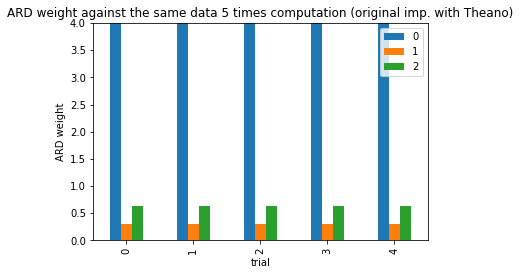

In [18]:
__df_theano_result = []
for i_trial, trial_result in enumerate(result_stacks):
    __df_theano_result.append(trial_result[0][0])
# end for
df_theano_result = pandas.DataFrame(__df_theano_result, index = list(range(0, n_trial)))
ax = df_theano_result.plot(kind='bar')
plt.title(f"ARD weight against the same data {n_trial} times computation (original imp. with Theano)")
plt.ylabel("ARD weight")
plt.xlabel("trial")
ax.set_ylim(0, 4)

(0.0, 4.0)

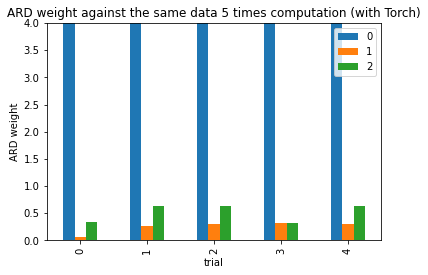

In [19]:
__df_torch_result = []
for i_trial, trial_result in enumerate(result_stacks):
    __df_torch_result.append(trial_result[0][1])
# end for
df_torch_result = pandas.DataFrame(__df_torch_result, index = list(range(0, n_trial)))
ax = df_torch_result.plot(kind='bar')
plt.title(f"ARD weight against the same data {n_trial} times computation (with Torch)")
plt.ylabel("ARD weight")
plt.xlabel("trial")
ax.set_ylim(0, 4)

### concolusion

With the above observation, we confirm that the ARD weight will __converage__ if we fix the input data and the sigma.

In [ ]:
%reset

# Study: with/without sigma optimizations

In [20]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas
import numpy

from model_criticism_mmd import ModelTrainerTheanoBackend, ModelTrainerTorchBackend, MMD, kernels_torch
import torch
device_obj = torch.device('cpu')

In [21]:
size = 200
x = numpy.random.normal(loc=1.0, scale=0.0, size=(200, 3))
y = numpy.random.normal(loc=1.0, scale=50.0, size=(200, 3))

#x_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))
#y_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))

#x = numpy.concatenate([numpy.reshape(x_1st_dim, (size, 1)), x_2_and_3_dim], axis=1)
#y = numpy.concatenate([numpy.reshape(y_1st_dim, (size, 1)), y_2_and_3_dim], axis=1)

x_train = x[:100]
y_train = y[:100]
x_val = x[100:150]
y_val = y[100:150]
x_test = x[150:]
y_test = y[150:]

for n_dim in [0, 1, 2]:
    print(f'{n_dim+1} dim. mean(x)={x[:,n_dim].mean()} mean(y)={y[:,n_dim].mean()} var(x)={x[:,n_dim].var()} var(y)={y[:,n_dim].var()}')
# end for
assert len(x_train) == len(y_train) == 100
assert len(x_val) == len(y_val) == 50
assert len(x_test) == len(y_test) == 50

1 dim. mean(x)=1.0 mean(y)=10.442223154140429 var(x)=0.0 var(y)=2501.4735323956756
2 dim. mean(x)=1.0 mean(y)=0.3669154815385541 var(x)=0.0 var(y)=2581.7030879744543
3 dim. mean(x)=1.0 mean(y)=-6.122438753596141 var(x)=0.0 var(y)=3024.6394982276734


In [22]:
n_epoch = 500
batch_size = 200
is_opt_sigma = False
# with sigma optimizations
trainer_theano = ModelTrainerTheanoBackend()
trained_obj_theano_without_sigma = trainer_theano.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, opt_sigma=is_opt_sigma, x_val=x_val, y_val=y_val, init_sigma_median=False, init_log_sigma=0.0)

mmd_estimator = MMD(kernel_function_obj=kernels_torch.BasicRBFKernelFunction(device_obj=device_obj, opt_sigma=is_opt_sigma),
                   device_obj=device_obj)
trainer_torch = ModelTrainerTorchBackend(mmd_estimator, device_obj)
trained_obj_torch = trainer_torch.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, x_val=x_val, y_val=y_val)

mmd2_theano, ratio_theano = trainer_theano.mmd_distance(x=x_test, y=y_test, sigma=trained_obj_theano_without_sigma.sigma)
mmd2_torch, ratio_torch = trainer_torch.mmd_distance(x=x_test, y=y_test)
print(f'MMD without the sigma optimization. Theano: {mmd2_theano} Torch: {mmd2_torch}')

Using sigma = 1.0
Compiling...
done
Input dim 3, representation dim 3
Training on 100 samples (batch 200), validation on 50 (batch 1000)
1 parameters to optimize: scales
     0: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s
     5: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s
    25: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s
    50: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s
   100: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s
   200: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s
   300: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 1s
   400: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 1s
   500: avg tr

MMD without the sigma optimization. Theano: 1.02 Torch: 1.0200000000073177


In [23]:
n_epoch = 500
batch_size = 200
is_opt_sigma = True
# with sigma optimizations
trainer_theano = ModelTrainerTheanoBackend()
trained_obj_theano_with_sigma = trainer_theano.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, opt_sigma=is_opt_sigma, x_val=x_val, y_val=y_val, init_sigma_median=True)

mmd_estimator = MMD(kernel_function_obj=kernels_torch.BasicRBFKernelFunction(device_obj=device_obj, opt_sigma=is_opt_sigma),
                   device_obj=device_obj)
trainer_torch = ModelTrainerTorchBackend(mmd_estimator, device_obj)
trained_obj_torch = trainer_torch.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, x_val=x_val, y_val=y_val)

mmd2_theano_with_sigma, ratio_theano = trainer_theano.mmd_distance(x=x_val, y=y_val, sigma=trained_obj_theano_with_sigma.sigma)
mmd2_torch_with_sigma, ratio_torch = trainer_torch.mmd_distance(x=x_val, y=y_val)
print(f'MMD with the sigma optimization. Theano: {mmd2_theano_with_sigma} Torch: {mmd2_torch_with_sigma}')

Starting with sigma = median; optimizing it
Compiling...
done
Getting median initial sigma value...
60.8
Input dim 3, representation dim 3
Training on 100 samples (batch 200), validation on 50 (batch 1000)
2 parameters to optimize: scales, log_sigma
     0: avg train MMD^2  0.391500 obj -2.537627,  avg val MMD^2  0.424009  obj -2.174944  elapsed: 0s  sigma: 60.8
     5: avg train MMD^2  0.492733 obj -2.678542,  avg val MMD^2  0.557446  obj -2.316401  elapsed: 0s  sigma: 52
    25: avg train MMD^2  1.010044 obj -9.220335,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s  sigma: 4.07
    50: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s  sigma: 1.11
   100: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s  sigma: 1.01
   200: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s  sigma: 1.01
   300: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^

MMD with the sigma optimization. Theano: 1.02 Torch: 1.02


### Conclusion

Sigma optimization does not seem to give effects to compute MMD^2 distance.